In [48]:
import xarray as xr
import numpy as np
import pandas as pd
import proplot as plot

## Read tendency data

In [64]:
date = '20200901' # 20190725 or 20200901
ds = xr.open_dataset(f'../data/wrfchem/export/{date}/tendency_o3_{date}.nc')

Set height as the dim

In [65]:
ds = ds.rename_dims({'bottom_top': 'z'}).assign_coords({'z': ds['height'].isel(Time=0).values})
# drop useless dims
ds = ds.drop_vars(['XTIME', 'datetime']).sel(Time=slice(f'{date} 04:00', f'{date} 06:00'))
ds

<xarray.Dataset>
Dimensions:  (Time: 12, z: 74)
Coordinates:
  * Time     (Time) datetime64[ns] 2020-09-01T04:10:00 ... 2020-09-01T06:00:00
  * z        (z) float32 0.05222276 0.11261963 ... 30.642664 31.111832
Data variables:
    height   (Time, z) float32 ...
    advh     (Time, z) float64 ...
    tmix     (Time, z) float64 ...
    chem     (Time, z) float64 ...
    o3dt     (Time, z) float64 ...

## Bin the data by height (1 km)

In [66]:
z_bins = xr.DataArray(np.arange(0, 17, 1), dims=['z'])
bin_ds = ds.groupby_bins("z", z_bins).mean()

In [67]:
o3dt = bin_ds['o3dt']#.to_dataframe().drop(columns=['XTIME', 'datetime'])
middle_bins = z_bins.rolling(z=2, center=True).mean()[1:]
# o3dt = o3dt.assign_coords({'z_bins': middle_bins.values})

## Time bounds

In [68]:
dt = o3dt.Time.diff(dim='Time')
t_bound = xr.concat([o3dt.Time[0].expand_dims('Time') - dt[0],
                     o3dt.Time,
                     o3dt.Time[-1].expand_dims('Time') + dt[-1]],
                    dim='Time').rolling(Time=2, center=True).mean()[1:]
t_bound

<xarray.DataArray (Time: 13)>
array(['2020-09-01T04:05:00.000000000', '2020-09-01T04:15:00.000000000',
       '2020-09-01T04:25:00.000000000', '2020-09-01T04:35:00.000000000',
       '2020-09-01T04:45:00.000000000', '2020-09-01T04:55:00.000000000',
       '2020-09-01T05:05:00.000000000', '2020-09-01T05:15:00.000000000',
       '2020-09-01T05:25:00.000000000', '2020-09-01T05:35:00.000000000',
       '2020-09-01T05:45:00.000000000', '2020-09-01T05:55:00.000000000',
       '2020-09-01T06:05:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * Time     (Time) datetime64[ns] 2020-09-01T04:10:00 ... 2020-09-01T06:00:00

## Heatmap of O3dt

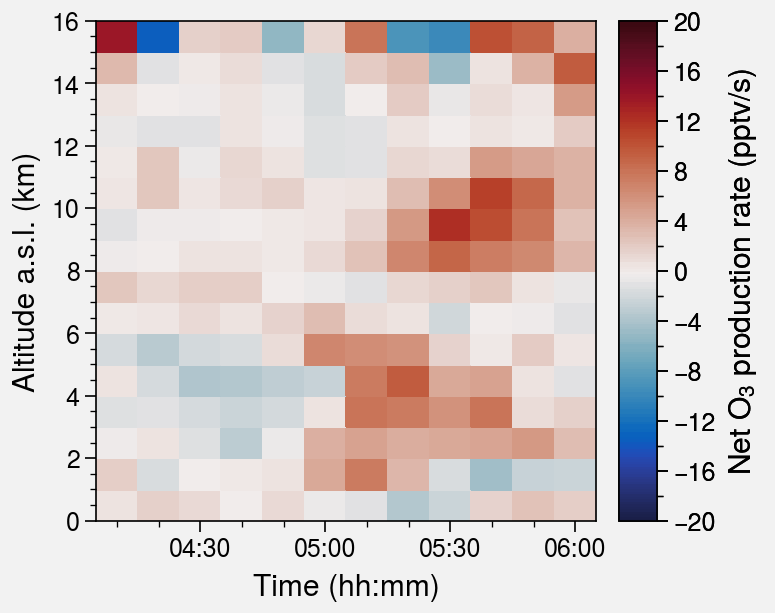

In [69]:
fig, axs = plot.subplots()

m = axs.pcolormesh(t_bound,
                   z_bins,
                   o3dt,
                   cmap='Balance',
                   vmin=-20,
                   vmax=20,
                   levels=256)

# calculate time step
dt = o3dt.Time.diff(dim='Time')/np.timedelta64(1, 'm')

# format the axis, especially the time format
axs.format(xlocator=('minute', range(0, 60, 30)),
           xminorlocator=('minute', range(0, 60, int(dt[0]))),
           xformatter='%H:%M',
           xrotation=0,
           xlabel='Time (hh:mm)',
           ylabel='Altitude a.s.l. (km)')

# add colorbar
axs.colorbar(m, ticks=4, minorticks=2, loc='r', label='Net O$_3$ production rate (pptv/s)')

# save figure
fig.savefig(f'../figures/o3dt_{date[:4]}.png')

We can compare with the defalut one to make sure the bounds are right:

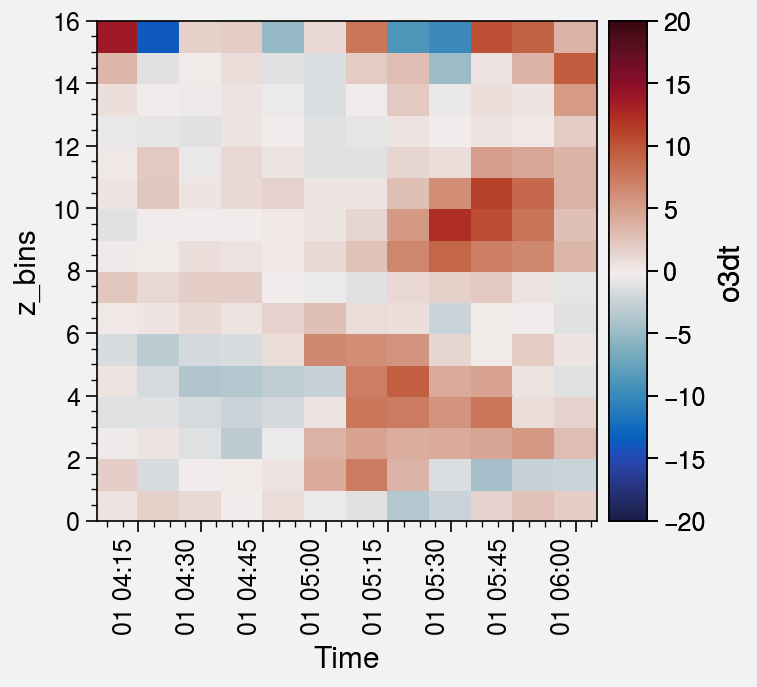

In [70]:
fig, ax = plot.subplots()
o3dt.plot(x='Time', y='z_bins', vmin=-20, vmax=20, cmap='Balance', levels=256)

## Plot the mean tendency in each bin

In [71]:
mean_ds = bin_ds.mean("Time")
std_ds = bin_ds.std("Time")

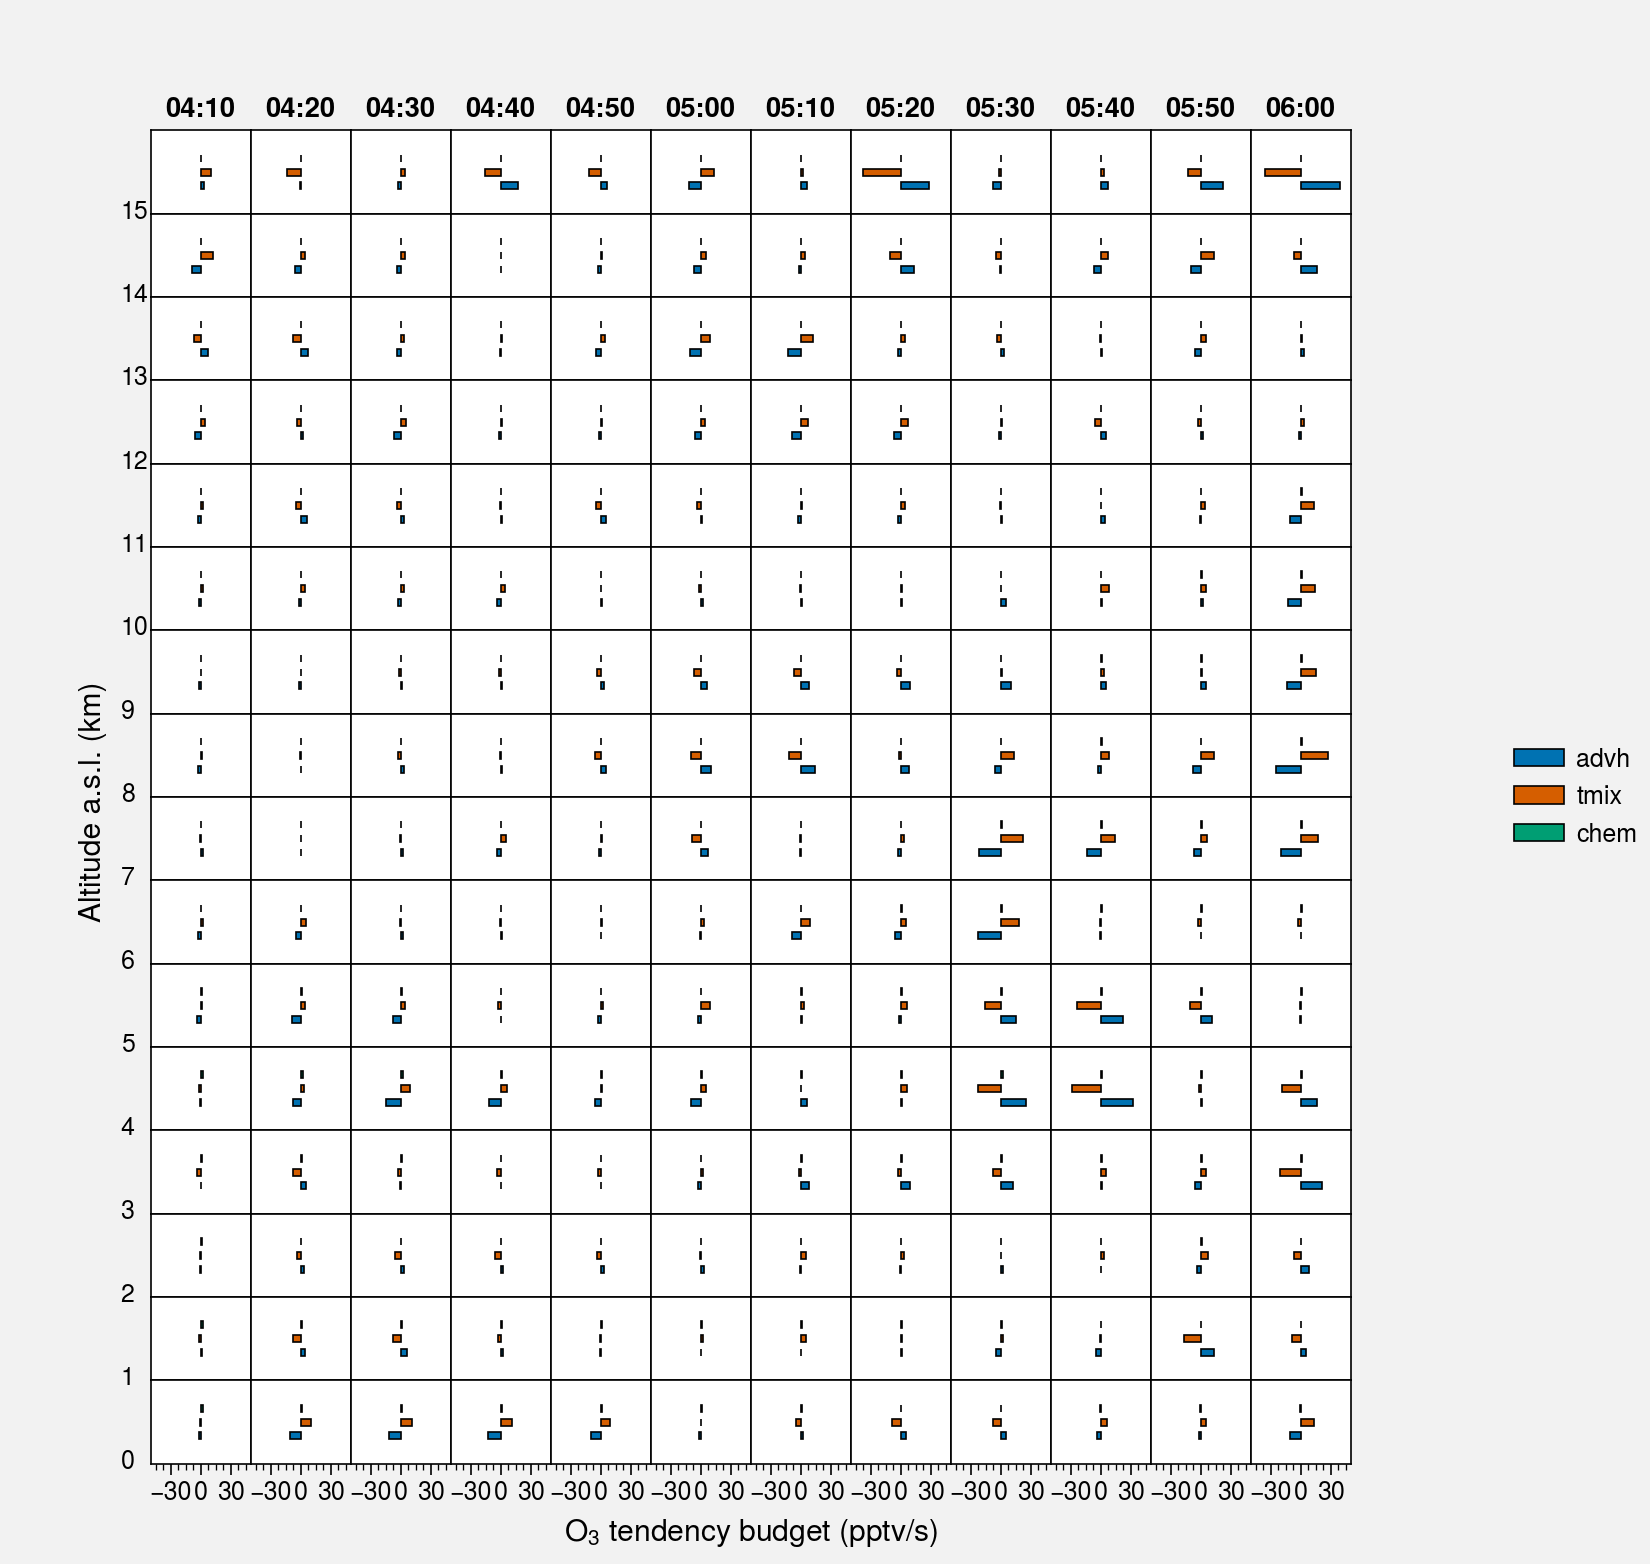

In [72]:
# create figure based on the dims of 'Time' and 'z_bins'
fig, axs = plot.subplots(axwidth=0.5,
                         aspect=(3,2.5),
                         nrows=bin_ds.sizes['z_bins'],
                         ncols=bin_ds.sizes['Time'],
                         space=0)

# increase the label font size
plot.rc.update(axeslabelsize='large')

# generate the time list for column labels
col_names = list(bin_ds.Time.dt.strftime('%H:%M').values)

# iterate for each subplot
for y in range(bin_ds.sizes['z_bins']):
    for x in range(bin_ds.sizes['Time']):
        ax = axs[bin_ds.sizes['z_bins']-y-1, x]
        # convert to pandas DataFrame for bar plot
        bin_df = bin_ds.isel(Time=x, z_bins=y).expand_dims('bin').to_dataframe()
#         bin_df['chem*50'] = bin_df['chem']
        bar = bin_df.plot.barh(ax=ax,
                               x='Time',
                               y=['advh', 'tmix', 'chem'],
                               xlim=(-50, 50),
                               ylabel='',
                               yticks=[],
                               legend=False)

        # add yticks only for the left y-axis
        if x == 0:
            ax.text(-80, -0.55, str(z_bins[y].values))

# set the limits and labels
axs.format(xlim=(-50, 50),
           xticks=30,
           yticks=[],
           xlabel='O$_3$ tendency budget (pptv/s)',
           ylabel='Altitude a.s.l. (km) \n',
           collabels=col_names,
           grid=False)

# add legend
patches, labels = ax.get_legend_handles_labels()
fig.legend(patches, labels, loc='r', ncols=1, frame=False)

# save fig
fig.savefig(f'../figures/tendency_o3_{date[:4]}.png')

## Plot the profile at Time_bins (2019)

Comparing the O3 PR and tendency, we can divide the time duration into three parts for the upper tropospheric O3:

- 04:10 -- 04:40
- 04:50 -- 05:20
- 05:30 -- 06:00

In [73]:
ds.Time

<xarray.DataArray 'Time' (Time: 12)>
array(['2020-09-01T04:10:00.000000000', '2020-09-01T04:20:00.000000000',
       '2020-09-01T04:30:00.000000000', '2020-09-01T04:40:00.000000000',
       '2020-09-01T04:50:00.000000000', '2020-09-01T05:00:00.000000000',
       '2020-09-01T05:10:00.000000000', '2020-09-01T05:20:00.000000000',
       '2020-09-01T05:30:00.000000000', '2020-09-01T05:40:00.000000000',
       '2020-09-01T05:50:00.000000000', '2020-09-01T06:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * Time     (Time) datetime64[ns] 2020-09-01T04:10:00 ... 2020-09-01T06:00:00

In [74]:
'''
Currently, `xarray` doesn't support multiple groupby_bins:
https://github.com/pydata/xarray/issues/2488

We have to create a new DataArray and use `slice` to
get the `mean` and `std` from the multidimentional data
'''

# set the time bins
t_bins = pd.to_datetime([f'{date} 04:10', f'{date} 04:40', f'{date} 05:20', f'{date} 06:00'])

# create the DataArray for saving ozone profiles
profiles = ds.isel(z=slice(None, o3dt.sizes['z_bins']),
                   Time=slice(None, len(t_bins)-1)).assign_coords({'z': middle_bins})

# copy for saving std
profiles_std = profiles.copy()

mean_list, std_list = [], []
# set new values for coordinates
for t in range(len(t_bins)-1):
    subset_ds = ds.sel(Time=slice(t_bins[t], t_bins[t+1])).groupby_bins("z", z_bins)
    mean_ds = subset_ds.mean(...)
    std_ds = subset_ds.std(...)
    mean_list.append(mean_ds.expand_dims('Time'))
    std_list.append(std_ds.expand_dims('Time'))
#     quantile_ds = subset_ds.quantile([0.05, 0.25, 0.75, 0.95])
#     median_ds = subset_ds.median(...)
#     display(quantile)

profiles = xr.concat(mean_list, dim='Time')
profiles_std = xr.concat(std_list, dim='Time')

['advh']


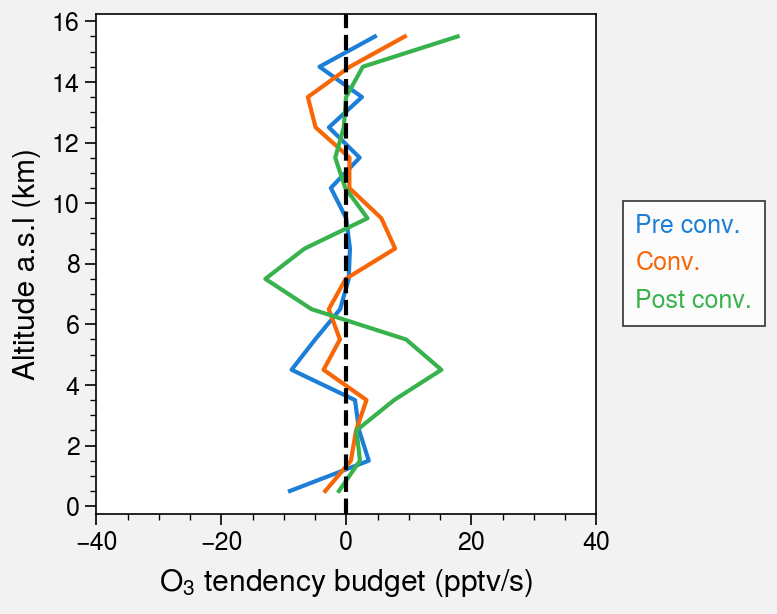

In [75]:
fig, axs = plot.subplots()


labels = ['Pre conv.', 'Conv.', 'Post conv.']
# line_styles = {'advh':'-', 'tmix':'--'}#, 'chem':'-.'}
line_styles = {'advh':'-'}#, 'chem':'-.'}
line_colors = ['blue7', 'orange7', 'green7']
legend = []

print(list(line_styles.keys()))
types = list(line_styles.keys())
for tend_type in types:
    for index,t in enumerate(profiles.Time):
        t_profile = profiles.sel(Time=t)
        
        line = axs.plot(t_profile[tend_type],
                        middle_bins,
                        label=labels[index],
                        linestyle=line_styles[tend_type],
                        color=line_colors[index])

#         t_profile_std = profiles_std.sel(Time=t)
#         axs.errorbar(t_profile['advh'],
#                      middle_bins,
#                      label=labels[index],
#                      yerr = None,
#                      xerr = t_profile_std['advh'],
#     #                     linestyle=line_styles[index],
#                      color=line_colors[index])
    
        if tend_type == types[0]:
            legend.append(line)

axs.axvline(0, color='k', linestyle='--')

l = axs.legend(legend,
               loc='r',
               ncols=1,
               handlelength=0,
               handletextpad=0)

for index,text in enumerate(l.get_texts()):
    text.set_color(line_colors[index])

axs.format(grid=False,
           xlim=(-40, 40),
           xlabel='O$_3$ tendency budget (pptv/s)',
           ylabel='Altitude a.s.l (km)')

fig.savefig(f'../figures/advh_profile_{date}.png')